In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from ipywidgets import interact_manual, IntSlider, FloatSlider
from sklearn.linear_model import LinearRegression

%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# Instrumental Variables

## Functions

In [35]:
iv_columns = ['instrument', 'treatment', 'confounder', 'outcome']

def generate_iv_data(n_samples, treat_effect, confound_effect, I_T, C_T, seed=42):
    """
    Generates IV data from a multivariate Gaussian.
    
    n_samples (int): the number samples to generate
    treat_effect (float): the true effect (coefficient) of the treatment on outcome
    confound_effect (float): the effect of the confounder (coefficient) on the outcome
    I_T (float): instrument strength, the covariance between the instrument and treatment
    C_T (float): confound strength, the covariance between the confound and treatment
    """
    
    idx_dict = {
        'I': 0,
        'T': 1,
        'C': 2,
        'O': 3
    }

    # vars:             I    T    C
    covar = np.array([[1.0, I_T, 0.0], # I
                      [I_T, 1.0, C_T], # T
                      [0.0, C_T, 1.0]])# C
    covar += np.eye(3,3)
    # vars:  I  T  C
    means = [0, 0, 0]

    # generate some data
    np.random.seed(seed)
    data = np.random.multivariate_normal(mean=means, cov=covar, size=n_samples)

    O = (confound_effect*data[:, idx_dict['C']]) + (treat_effect*(data[:, idx_dict['T']])) + np.random.normal(0,1,size=n_samples)

    data = np.concatenate([data,O.reshape(-1, 1)], axis=1)

    data_df = pd.DataFrame(data, columns=iv_columns)
    
    return data_df

## Sandbox

In [36]:
treat_effect = 2
confound_effect = 0
n_samples = 1000
I_T = 0.9 # instrument strength
C_T = 0.1 # confound strength
data_df = generate_iv_data(n_samples, treat_effect, confound_effect, I_T, C_T)

In [37]:
I_T = 1 # instrument strength
C_T = 1 # confound strength
covar = np.array([[1.0, I_T, 0.0], # I
                  [I_T, 1.0, C_T], # T
                  [0.0, C_T, 1.0]])# C

np.linalg.cholesky(covar + (np.eye(3,3)))

array([[1.41421356, 0.        , 0.        ],
       [0.70710678, 1.22474487, 0.        ],
       [0.        , 0.81649658, 1.15470054]])

In [38]:
data_df.corr()

,instrument,treatment,confounder,outcome
instrument,1.000000,0.440669,-0.061992,0.398518
treatment,0.440669,1.000000,0.026336,0.935986
confounder,-0.061992,0.026336,1.000000,0.033185
outcome,0.398518,0.935986,0.033185,1.000000


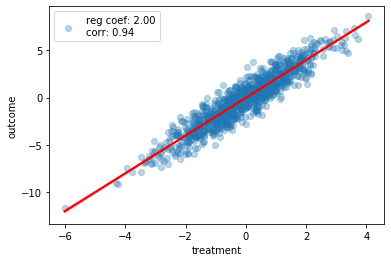

In [39]:
def plot_iv_scatter(x, y, data_df, ax):
    
    scatter_kws = {
        'alpha': 0.3
    }

    line_kws = {
        'color': 'red'
    }
    reg = LinearRegression(fit_intercept=True)
    reg.fit(data_df[[x]], data_df[y])
    
    corr= np.corrcoef(data_df[x], data_df[y])[0,1]
    sns.regplot(x=x, y=y, data=data_df, 
                scatter_kws=scatter_kws,
                line_kws=line_kws,
                label="reg coef: {:.2f}\ncorr: {:.2f}".format(reg.coef_[0], corr),
                ax=ax)
    ax.legend()
ax = plt.gca()
plot_iv_scatter('treatment', 'outcome', data_df, ax)

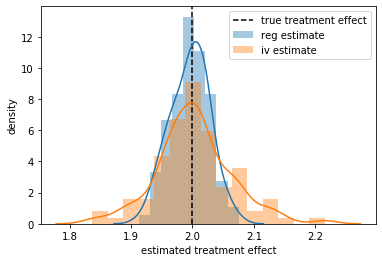

In [45]:
n_trials = 100

def plot_iv_dist(n_trials, n_samples, treat_effect, confound_effect, I_T, C_T, ax):
    reg_estimates = []
    iv_estimates = []
    for t in range(n_trials):
        df = generate_iv_data(n_samples, treat_effect, confound_effect, I_T, C_T, seed=t)

        reg = LinearRegression(fit_intercept=True)
        reg.fit(df[['treatment']], df['outcome'])
        reg_estimates.append(reg.coef_)

        stage1 = LinearRegression(fit_intercept=True)
        stage1.fit(df[['instrument']], df['treatment'])
        t_hat = stage1.predict(df[['instrument']])
        stage2 = LinearRegression(fit_intercept=True)
        stage2.fit(t_hat.reshape(-1,1), df['outcome'])
        iv_estimates.append(stage2.coef_)

    ax = plt.gca()
    ax.axvline(x=treat_effect, color='black', ls='--', label="true treatment effect")

    sns.distplot(reg_estimates, ax=ax, label="reg estimate")
    sns.distplot(iv_estimates, ax=ax, label="iv estimate")
    ax.set_ylabel("density")
    ax.set_xlabel("estimated treatment effect")
    ax.legend()

ax = plt.gca()
plot_reg_iv_dist(n_trials, n_samples, treat_effect, confound_effect, I_T, C_T, ax)

## Widget

In [46]:
n_samples = 500
n_trials = 50
x = 'treatment'
y = 'outcome'

style = {'description_width': 'initial'}
n_slider = IntSlider(style=style, description="sample size", min=100, max=1000, step=100)
treat_slider = IntSlider(style=style, description="treatment effect", min=-5, max=5, value=1)
confound_slider = IntSlider(style=style, description="confounder effect",min=-5, max=5, value=-1)
iv_str_slider = FloatSlider(style=style, description="instrument strength", min=-1, max=1, value=0.5)
confound_str_slider = FloatSlider(style=style, description="confounder strength", min=-1, max=1, value=0.5)
@interact_manual(n_samples=n_slider,
                 x=iv_columns, y=iv_columns, 
                 treat_effect=treat_slider, 
                 confound_effect=confound_slider, 
                 instrument_str=iv_str_slider, 
                 confounder_str=confound_str_slider)
def show_iv_widget(n_samples, x, y, treat_effect, confound_effect, instrument_str, confounder_str):
    data_df = generate_iv_data(n_samples, treat_effect, confound_effect, instrument_str, confounder_str)
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
    
    plot_iv_scatter(x, y, data_df, ax1)
    plot_iv_dist(n_trials, n_samples, treat_effect, confound_effect, instrument_str, confounder_str, ax2)
    fig.suptitle("Instrumental Variable Interactive Widget")
#show_iv_widget(x, y, treat_effect, confound_effect, I_T, C_T)

interactive(children=(IntSlider(value=100, description='sample size', max=1000, min=100, step=100, style=Slide…

# Differences in differences

## Sandbox

In [47]:
def generate_did_data(n_samples, treat_time_effect, control_time_effect, control_offset, treat_effect, seed):
    """
    Generates simple diff-in-diff data.
    
    Args:
        n_samples (int): number of samples to generate
        treat_time_effect (float): 
        control_time_effect (float): 
        control_offset (float): 
        seed (int):
    """
    np.random.seed(seed)
    max_time = 10
    cutoff = max_time / 2

    treat_indicator = np.random.choice(2, size=n_samples)
    time = np.random.uniform(low=0, high=max_time, size=n_samples)

    outcome = (treat_time_effect * treat_indicator * time) + \
              (control_time_effect * (1-treat_indicator) * time) + \
              (control_offset * (1-treat_indicator)) + \
              (treat_effect * treat_indicator * (time > cutoff).astype(int)) + \
              np.random.normal(0,1, size=n_samples)


    did_df = pd.DataFrame()
    did_df['time'] = time
    did_df['treat_indicator'] = treat_indicator
    did_df['pre_post_indicator'] = (time > cutoff).astype(int)
    did_df['outcome'] = outcome
    
    return did_df

In [48]:
n_samples = 500
seed = 42
treat_time_effect = 1
control_time_effect = 1
control_offset = -2
treat_effect = 2

did_df = generate_did_data(n_samples, treat_time_effect, control_time_effect, control_offset, treat_effect, seed)

In [75]:
def plot_did_scatter(did_df, ax):
    """
    Plots the diff in diff scatter plot.
    
    """

    sns.scatterplot(x='time', y='outcome', hue='treat_indicator', 
                    data=did_df, alpha=0.3, legend=False, ax=ax)
    ax.axvline(x=cutoff, label="treat cutoff", color='black', ls='--')

    control_pre = did_df.loc[(did_df['time'] < cutoff) & (did_df['treat_indicator'] == 0)]
    control_post = did_df.loc[(did_df['time'] >= cutoff) & (did_df['treat_indicator'] == 0)]

    treat_pre = did_df.loc[(did_df['time'] < cutoff) & (did_df['treat_indicator'] == 1)]
    treat_post = did_df.loc[(did_df['time'] >= cutoff) & (did_df['treat_indicator'] == 1)]
    
    x_pre = np.linspace(0,5).reshape(-1,1)
    x_post = np.linspace(5,10).reshape(-1,1)
    
    ctl_pre_reg = LinearRegression().fit(control_pre[['time']], control_pre['outcome']).predict(x_pre)
    ctl_post_reg = LinearRegression().fit(control_post[['time']], control_post['outcome']).predict(x_post)

    trt_pre_reg = LinearRegression().fit(treat_pre[['time']], treat_pre['outcome']).predict(x_pre)
    trt_post_reg = LinearRegression().fit(treat_post[['time']], treat_post['outcome']).predict(x_post)

    
    ax.plot(x_pre, ctl_pre_reg, ls="--", label="control outcome", color="C0")
    ax.plot(x_post, ctl_post_reg, ls="--", color="C0")
    
    ax.plot(x_pre, trt_pre_reg, ls="--", label="treat outcome", color="orange")
    ax.plot(x_post, trt_post_reg, ls="--", color="orange")
    ax.legend()
    

In [76]:
#     control_pre = np.mean(did_df.loc[(did_df['time'] < cutoff) & (did_df['treat_indicator'] == 0), 'outcome'])
#     control_post = np.mean(did_df.loc[(did_df['time'] >= cutoff) & (did_df['treat_indicator'] == 0), 'outcome'])

#     treat_pre = np.mean(did_df.loc[(did_df['time'] < cutoff) & (did_df['treat_indicator'] == 1), 'outcome'])
#     treat_post = np.mean(did_df.loc[(did_df['time'] >= cutoff) & (did_df['treat_indicator'] == 1), 'outcome'])

#     control_pre = LinearRegression().fit(did_df)
    
#     ax.axhline(y=control_pre, xmax=0.5, ls="--", label="control outcome")
#     ax.axhline(y=control_post, xmin=0.5, ls="--")

#     ax.axhline(y=treat_pre, xmax=0.5, ls="--", color="orange", label="treat outcome")
#     ax.axhline(y=treat_post, xmin=0.5, ls="--", color="orange")

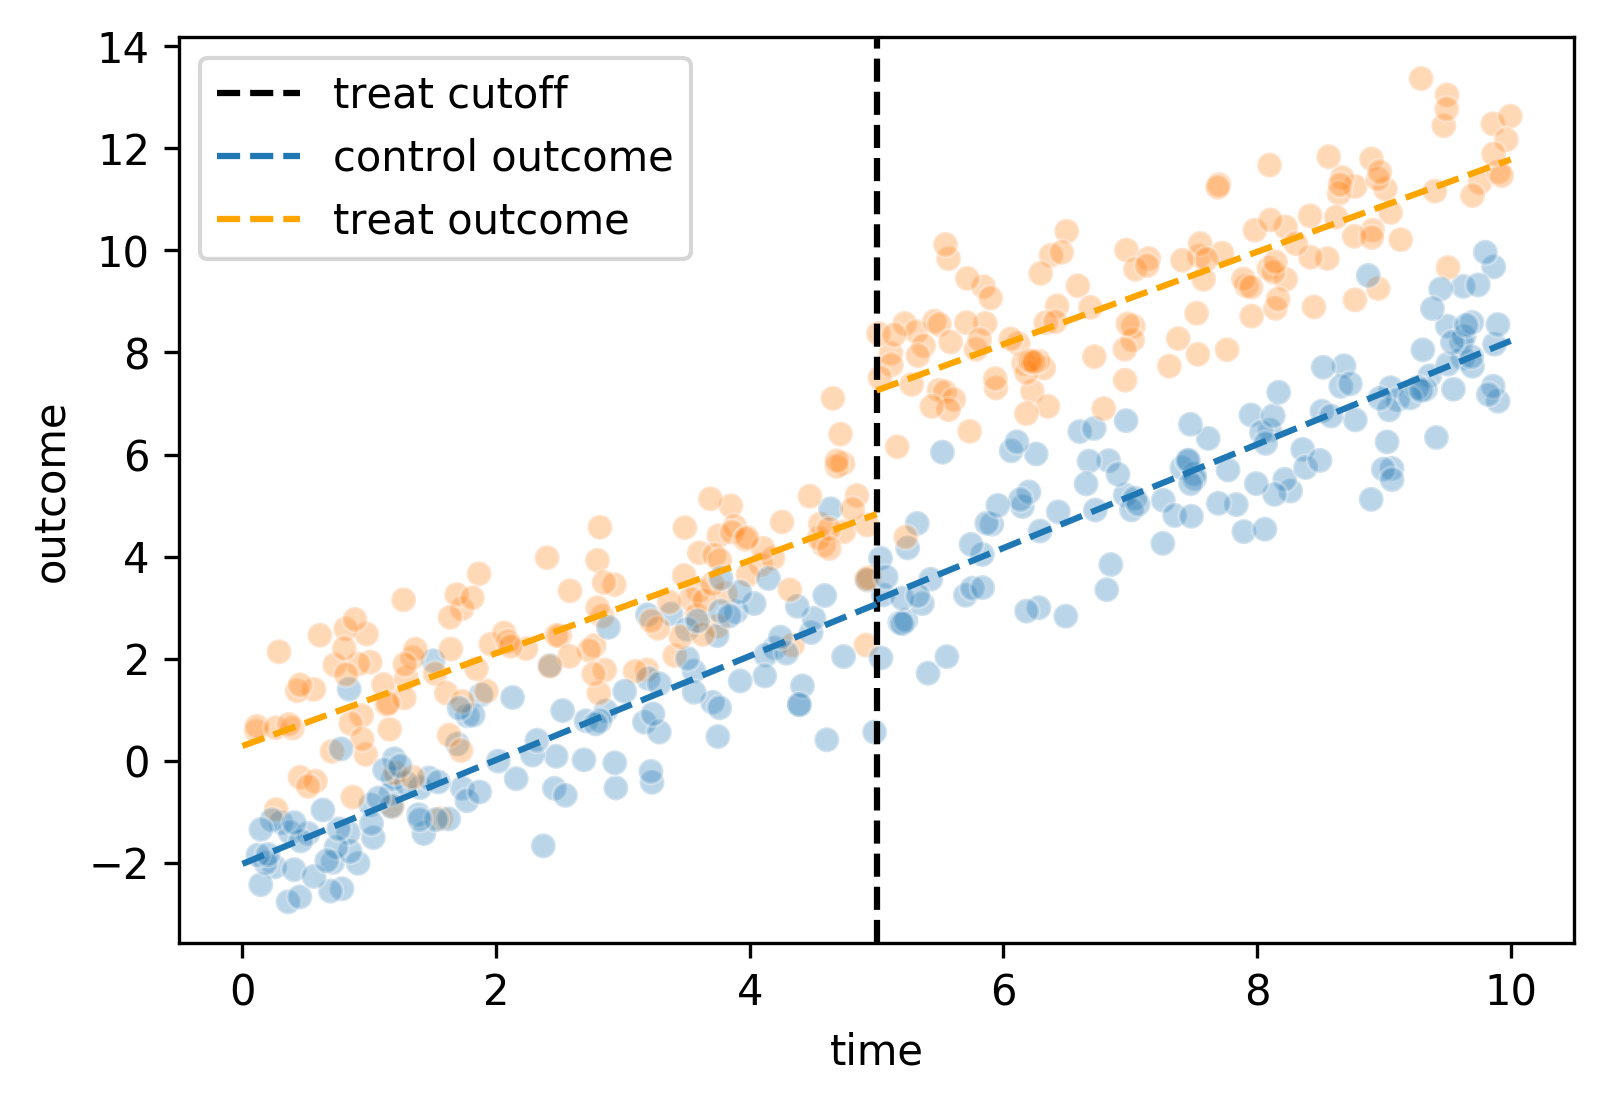

In [77]:
ax = plt.gca()
plot_did_scatter(did_df, ax)

In [55]:
n_trials = 100

def plot_did_dist(n_trials, n_samples, treat_time_effect, control_time_effect, control_offset, treat_effect, ax):
    diff_estimates = []
    did_estimates = []
    for t in range(n_trials):
        did_df = generate_did_data(n_samples, treat_time_effect, control_time_effect, control_offset, treat_effect, seed=t)

        control_pre = np.mean(did_df.loc[(did_df['time'] < cutoff) & (did_df['treat_indicator'] == 0), 'outcome'])
        control_post = np.mean(did_df.loc[(did_df['time'] >= cutoff) & (did_df['treat_indicator'] == 0), 'outcome'])

        treat_pre = np.mean(did_df.loc[(did_df['time'] < cutoff) & (did_df['treat_indicator'] == 1), 'outcome'])
        treat_post = np.mean(did_df.loc[(did_df['time'] >= cutoff) & (did_df['treat_indicator'] == 1), 'outcome'])

        diff_estimates.append((treat_post - treat_pre))
        did_estimates.append((treat_post - treat_pre) - (control_post - control_pre))
        
    ax.axvline(x=treat_effect, color='black', ls='--', label="true treatment effect")

    sns.distplot(diff_estimates, ax=ax, label="single difference estimate")
    sns.distplot(did_estimates, ax=ax, label="diff in diff estimate")
    ax.set_ylabel("density")
    ax.set_xlabel("estimated treatment effect")
    ax.legend()

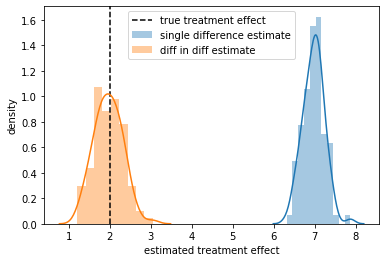

In [56]:
ax = plt.gca()
plot_did_dist(n_trials, n_samples, treat_time_effect, control_time_effect, control_offset, treat_effect, ax)

## Widget


In [80]:
style = {'description_width': 'initial'}
n_slider = IntSlider(style=style, description="sample size", min=100, max=1000, step=100)
treat_slider = IntSlider(style=style, description="treatment effect", min=-5, max=5, value=1)
time_effect_slider = FloatSlider(style=style, description="time effect", min=-2, max=2, value=1)
time_ratio_slider = FloatSlider(style=style, description="time ratio (1 for parallel trends)", min=-2, max=2, value=1)
control_slider = IntSlider(style=style, description="control group offset", min=-5, max=5, value=1)

@interact_manual(n_samples=n_slider,
                 treat_effect=treat_slider, 
                 time_effect=time_effect_slider, 
                 time_ratio=time_ratio_slider, 
                 control_offset=control_slider)
def show_did_widget(n_samples, treat_effect, time_effect, time_ratio, control_offset):
    treat_time_effect = time_effect
    control_time_effect = time_effect * time_ratio
    did_df = generate_did_data(n_samples, treat_time_effect, control_time_effect, control_offset, treat_effect, seed=42)
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
    plot_did_scatter(did_df, ax1)
    plot_did_dist(n_trials, n_samples, treat_time_effect, control_time_effect, control_offset, treat_effect, ax2)
    fig.suptitle("Difference in Difference Interactive Widget")

interactive(children=(IntSlider(value=100, description='sample size', max=1000, min=100, step=100, style=Slide…

# Regression Discontinuity Design

## Sandbox

In [162]:
def generate_rdd_data(n_samples, treat_effect, confound_effect, C_R, seed=42):
    """
    Generates sharp RDD data.
    
    n_samples (int): the number samples to generate
    treat_effect (float): the true effect (coefficient) of the treatment on outcome
    confound_effect (float): the effect of the confounder (coefficient) on the outcome
    running_effect (float): the effect of the running variable on the outcome, in addition to the treatment effect
    C_R (float): confound strength, the covariance between the confound and running var
    """
    
    
    
    
    # vars:             R    C 
    covar = np.array([[1.0, C_R],  # R
                      [C_R, 1.0]]) # C
    covar += np.eye(2,2)
    # vars:  R, C
    means = [0, 0]

    # generate some data
    np.random.seed(seed)
    data = np.random.multivariate_normal(mean=means, cov=covar, size=n_samples)
    
    running = data[:,0]
    confound = data[:,1]
    treat = (running > 0).astype(int)
    
    #outcome = (confound_effect*confound) + (treat_effect*treat) + (running_effect * running) + np.random.normal(0,1,size=n_samples)
    outcome = (confound_effect*confound) + (treat_effect*treat) + np.random.normal(0,1,size=n_samples)

    rdd_df = pd.DataFrame()
    rdd_df['running'] = running
    rdd_df['confound'] = confound
    rdd_df['treat'] = treat
    rdd_df['outcome'] = outcome
    
    return rdd_df

In [163]:
n_samples = 1000
treat_effect = 5
confound_effect = 5
C_R = 0.9
seed = 0

rdd_df = generate_rdd_data(n_samples, treat_effect, confound_effect, C_R, seed=42)

def plot_rdd_scatter(x,y, rdd_df, ax):
    
    sns.scatterplot(x=x, y=y, data=rdd_df, alpha=0.5, ax=ax)
    if x == "running":
        ax.axvline(x=0, color="black", ls="--", label = "treatment cutoff")
        
        x_pre = np.linspace(rdd_df['running'].min(), 0).reshape(-1,1)
        x_post = np.linspace(0, rdd_df['running'].max()).reshape(-1,1)
        
        left_cutoff = rdd_df[(rdd_df['running'] < 0)]
        right_cutoff = rdd_df[(rdd_df['running'] > 0)]
        
        left_reg = LinearRegression().fit(left_cutoff[['running']], left_cutoff['outcome']).predict(x_pre)
        right_reg = LinearRegression().fit(right_cutoff[['running']], right_cutoff['outcome']).predict(x_post)

        ax.plot(x_pre, left_reg, color="red", ls="--", label="pre/post regression")
        ax.plot(x_post, right_reg, color="red", ls="--")
        ax.legend()
        
        


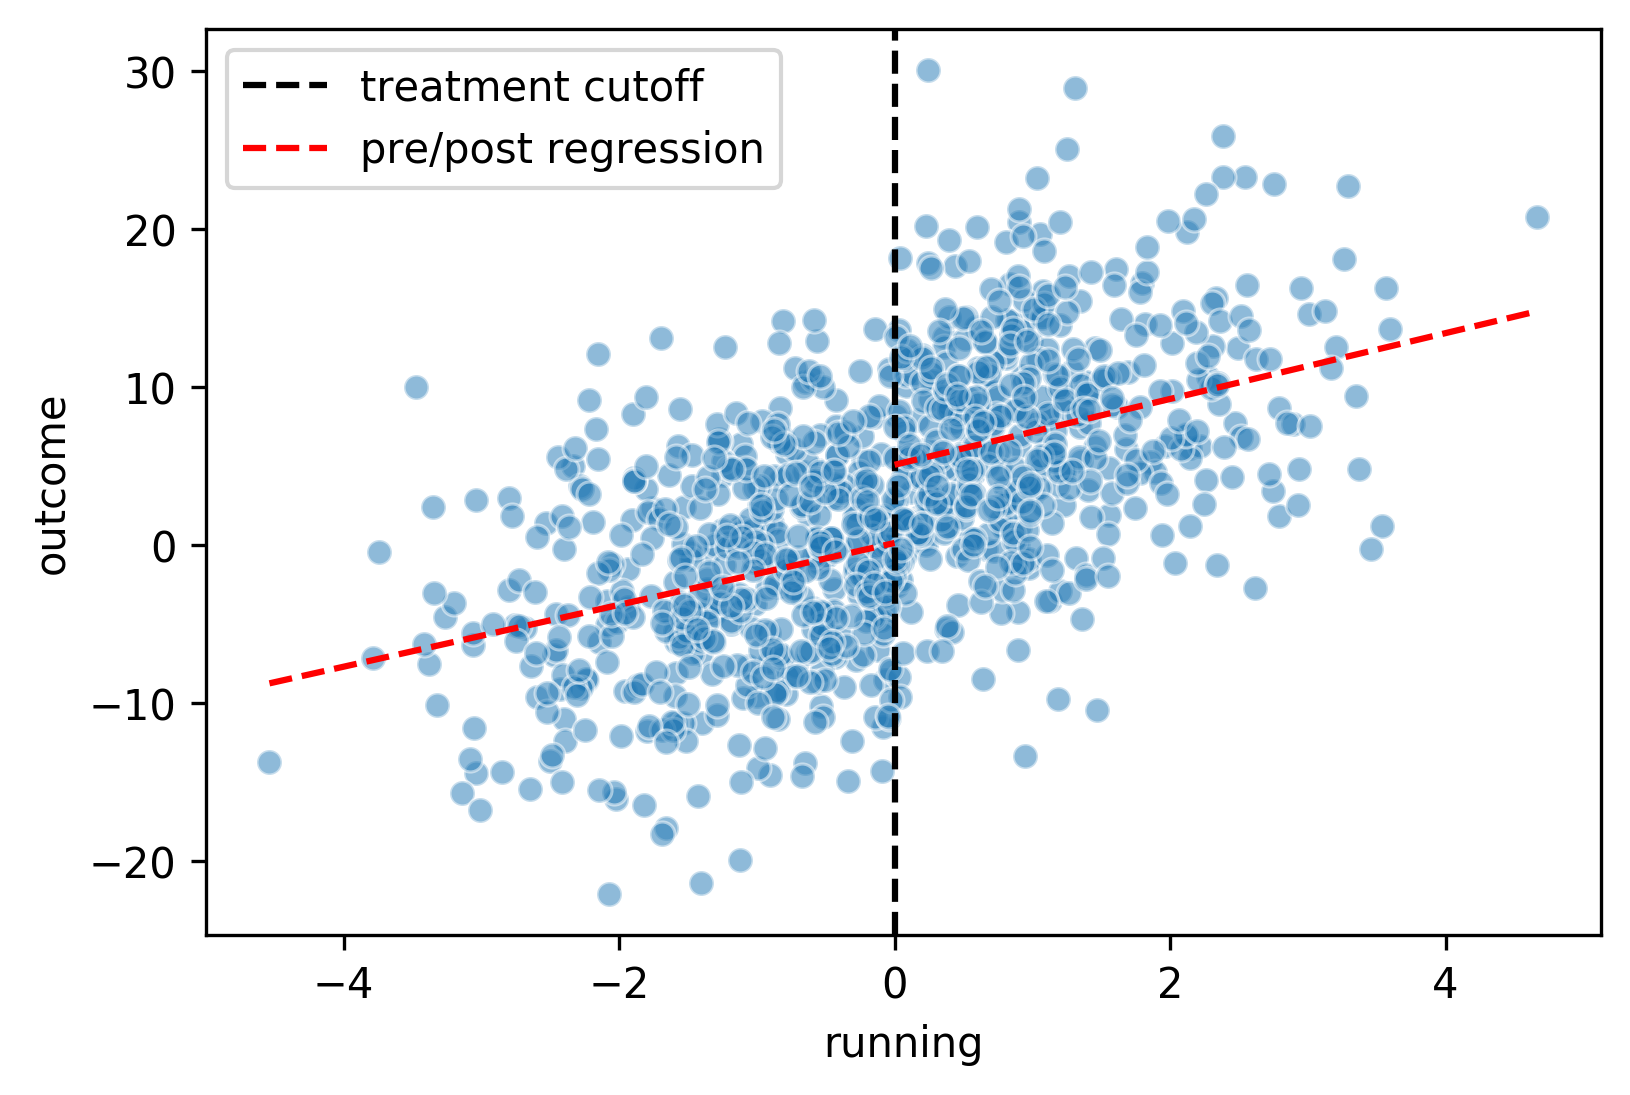

In [164]:
ax = plt.gca()
plot_rdd_scatter("running", "outcome", rdd_df, ax)

In [165]:
test_reg = LinearRegression().fit(rdd_df[['treat']], rdd_df['outcome'])
test_reg.coef_

array([9.41441537])

In [166]:
left_cutoff = rdd_df[(rdd_df['running'] > -5) & (rdd_df['running'] < 0)]
right_cutoff = rdd_df[(rdd_df['running'] > 0) & (rdd_df['running'] < 5)]

In [167]:
np.mean(right_cutoff['outcome']) - np.mean(left_cutoff['outcome'])

9.414415370025544

In [168]:
left_reg = LinearRegression().fit(left_cutoff[['running']], left_cutoff['outcome']).intercept_
right_reg = LinearRegression().fit(right_cutoff[['running']], right_cutoff['outcome']).intercept_

right_reg - left_reg

4.946967625780436

In [171]:
def plot_rdd_dist(n_trials, n_samples, treat_effect, confound_effect, C_R, bandwidth, ax):
    reg_estimates = []
    rdd_estimates = []
    for t in range(n_trials):
        rdd_df = generate_rdd_data(n_samples, treat_effect, confound_effect, C_R, seed=t)

        reg = LinearRegression().fit(rdd_df[['treat']], rdd_df['outcome'])
        reg_estimates.append(reg.coef_)

        left_cutoff = rdd_df[(rdd_df['running'] > (-1*bandwidth)) & (rdd_df['running'] < 0)]
        right_cutoff = rdd_df[(rdd_df['running'] > 0) & (rdd_df['running'] < bandwidth)]
        
        left_reg = LinearRegression().fit(left_cutoff[['running']], left_cutoff['outcome']).intercept_
        right_reg = LinearRegression().fit(right_cutoff[['running']], right_cutoff['outcome']).intercept_
        
        rdd_estimates.append(right_reg - left_reg)

    ax = plt.gca()
    ax.axvline(x=treat_effect, color='black', ls='--', label="true treatment effect")

    sns.distplot(reg_estimates, ax=ax, label="reg estimate")
    sns.distplot(rdd_estimates, ax=ax, label="rdd estimate")
    ax.set_ylabel("density")
    ax.set_xlabel("estimated treatment effect")
    ax.legend()

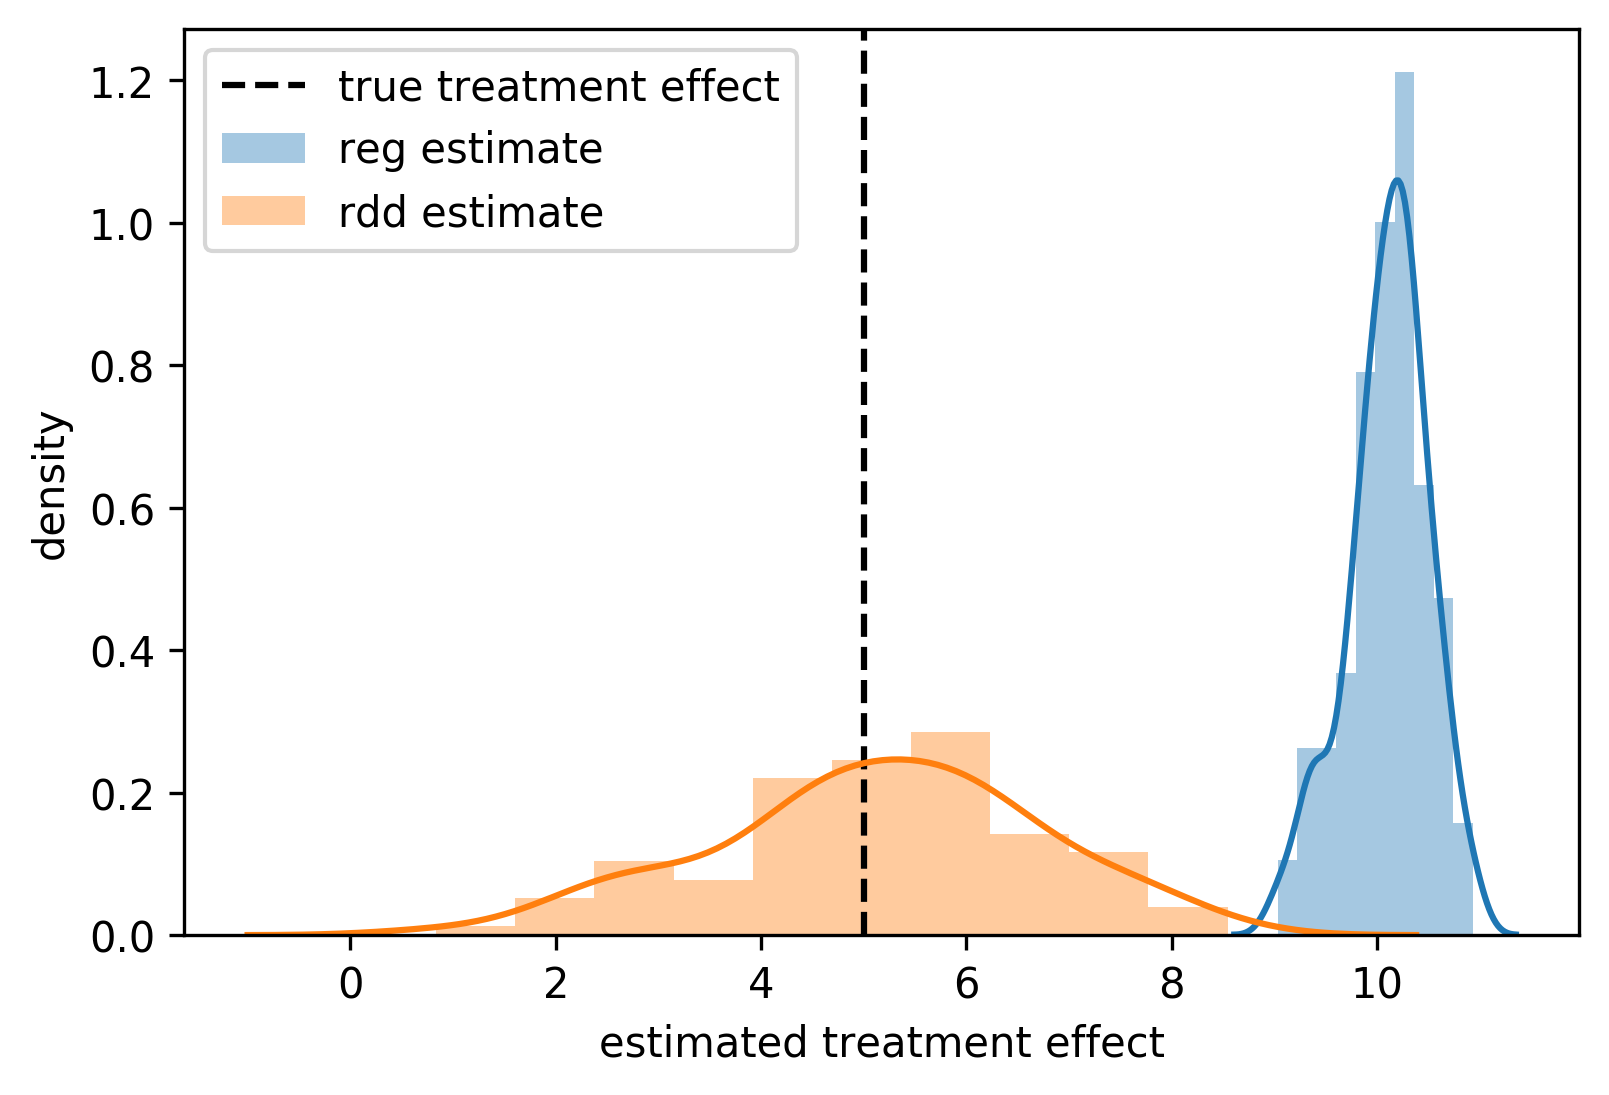

In [173]:
n_trials = 100
bandwidth=0.5
ax = plt.gca()
plot_rdd_dist(n_trials, n_samples, treat_effect, confound_effect, C_R, bandwidth, ax)

## Widget

In [179]:
style = {'description_width': 'initial'}
rdd_columns = ["treat", "confound", "running", "outcome"]
n_slider = IntSlider(style=style, description="sample size", min=100, max=1000, step=100)
treat_slider = IntSlider(style=style, description="treatment effect", min=-5, max=5, value=1)
confound_slider = IntSlider(style=style, description="confounder effect",min=-5, max=5, value=-1)
bandwidth_slider = FloatSlider(style=style, description="bandwidth",min=0.1, max=5, value=0.5)
confound_str_slider = FloatSlider(style=style, description="confounder strength", min=-1, max=1, value=0.5)

@interact_manual(n_samples=n_slider,
                 x=rdd_columns, y=rdd_columns, 
                 treat_effect=treat_slider, 
                 confound_effect=confound_slider, 
                 bandwidth=bandwidth_slider, 
                 C_R=confound_str_slider)
def show_rdd_widget(n_samples, x, y, treat_effect, confound_effect, bandwidth, C_R):
    rdd_df = generate_rdd_data(n_samples, treat_effect, confound_effect, C_R)
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
    
    plot_rdd_scatter(x, y, rdd_df, ax1)
    plot_rdd_dist(n_trials, n_samples, treat_effect, confound_effect, C_R, bandwidth, ax2)
    fig.suptitle("Regression Discontinuity Interactive Widget")

interactive(children=(IntSlider(value=100, description='sample size', max=1000, min=100, step=100, style=Slide…